#### Transfer Learing as in https://github.com/Shaam93/Building-a-classifer-with-Pytorch/blob/master/Classification_of_flowers_Train_val_test.ipynb and in https://medium.com/p/9574e74d17ad#1650

Import

In [1]:
import time
import json
import copy

import PIL 
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, models, datasets

from torchvision.io import read_image
# available ResNet : 18, 34, 50, 101, 152 -layers
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
import matplotlib.pyplot as plt

Data train-valid-test preparation

In [3]:
train_dir = 'C:/Users/cmarmy/Documents/STDL/Beeches/DL/data/train'
valid_dir = 'C:/Users/cmarmy/Documents/STDL/Beeches/DL/data/valid'
test_dir = 'C:/Users/cmarmy/Documents/STDL/Beeches/DL/data/test'

dirs = {'train': train_dir,
        'valid': valid_dir,
        'test' : test_dir
        }

In [153]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(45), # between -45 and 45°
        #transforms.RandomResizedCrop(224), # A crop of random size (default: of 0.08 to 1.0) of the original size and a random aspect ratio (default: of 3/4 to 4/3) 
        #transforms.RandomHorizontalFlip(),
        transforms.Resize(224), 
        transforms.Pad((0,336), fill=0, padding_mode='constant'),
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(), #numpy.ndarray(H x W x C) in the range [0, 255] to torch.FloatTensor(C x H x W) in the range [0.0, 1.0]
        transforms.Normalize([0.485, 0.456, 0.406], # to be applied on tensor only. sequence of means and std for each channel
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224), 
        transforms.Pad((0,336), fill=0, padding_mode='constant'),
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224), 
        transforms.Pad((0,336), fill=0, padding_mode='constant'),
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [154]:
# Load the datasets with ImageFolder
# ImageFolder is using the directory structure to create a classes field.
# Does not support empty directory
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
# load the data into batches
# think to devide, drop_last=True if necessary

# !! batch size !!
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [2]:
class_names = image_datasets['train'].classes
print(class_names)

with open('C:/Users/cmarmy/Documents/STDL/Beeches/DL/data/cat_to_name.json', 'r') as f:
    label_map = json.load(f)

NameError: name 'image_datasets' is not defined

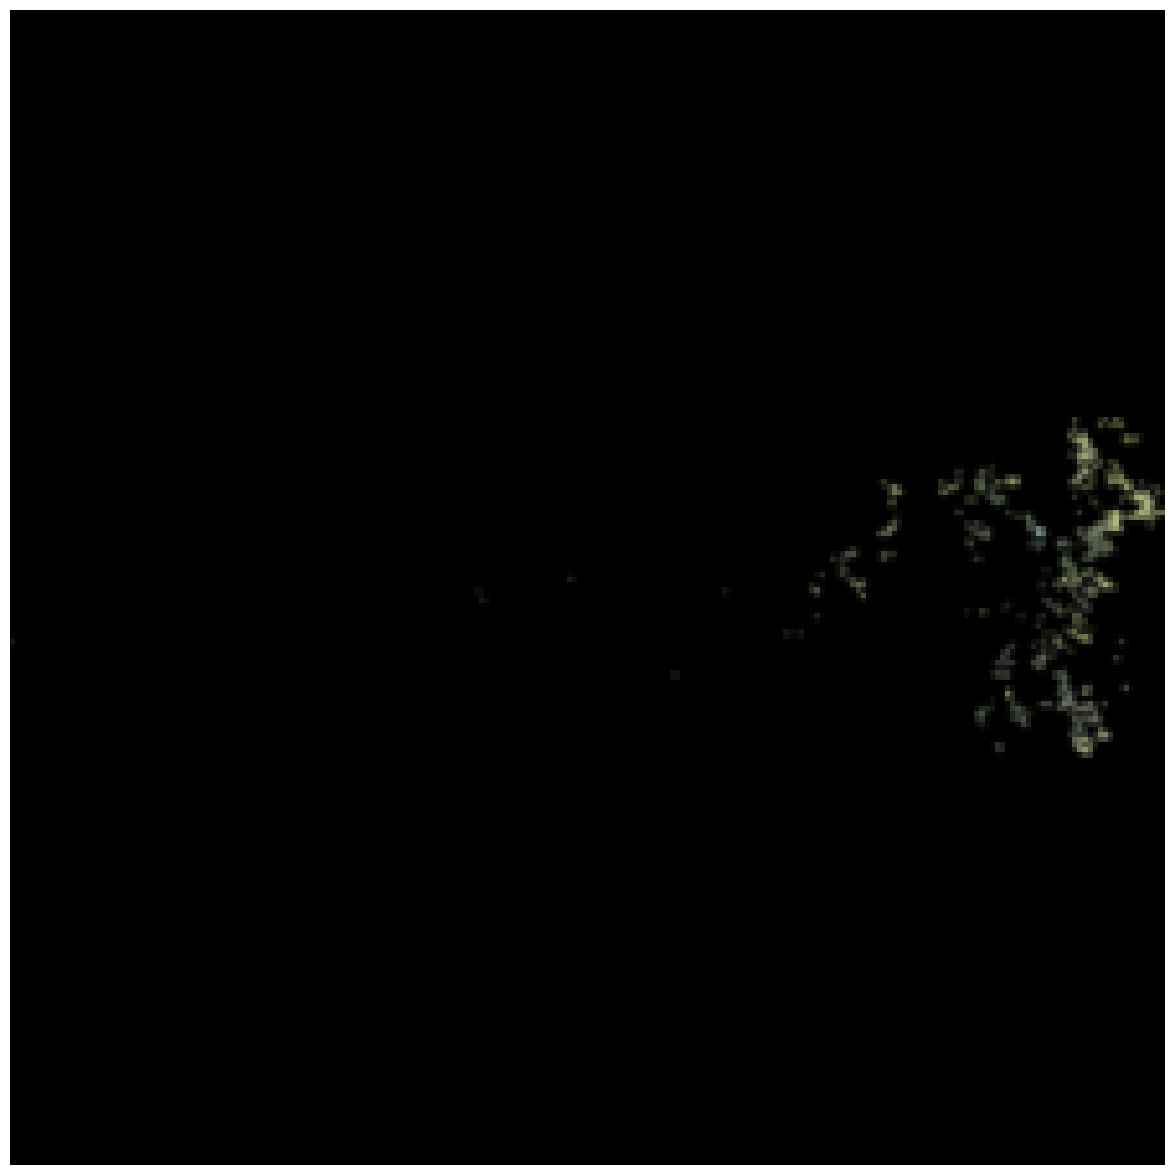

In [156]:
#check images after transform
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0)) # if the image is already a tensor  
    else:
        image = np.array(image).transpose((1, 2, 0)) # put channel in the right order
        
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406]) # backward some of the transformations
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8) # plot each batch with 8 element per row 
imshow(out)

Model

In [ ]:
# model = models.resnet18(pretrained=True) deprecated
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model

In [158]:
# Change in the model (see previous cell) : (fc): Linear(in_features=512, out_features=1000, bias=True) 
# we have now only 102 classes to predict
model.fc = nn.Linear(512, 3)

In [159]:
# Set CPU or GPU
# I only have a non-CUDA-compatible GPU card. Could be an alternative https://github.com/artyom-beilis/pytorch_dlprim

if torch.cuda.is_available():
  device= torch.device('cuda')
  print("CUDA is avaialble")
else:
  device= torch.device('cpu')
  print("Only CPU")


Only CPU


Option A : train/validate the model

In [163]:
#training/validating function 
# this part of code is from https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
#I changed minor things for my convinience
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # deepcopy() vs. (shallow) copy(): copy the object and the objects inside vs. copy object and reference object inside.
    best_acc = 0.0

    optimizer.step() # this new line added 

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #iterate on the batches
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # inputs, batch of images; outputs, tensor of #image per #classes
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels) # labels are the true labels for the batch.

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves. "loss derivatives for the parameters"
                        optimizer.step() # parameter update

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
     

criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Number of epochs
eps=5

model = train_model(model, criteria, optimizer, scheduler, eps, 'cpu')

Epoch 1/5
----------


Traceback (most recent call last):
  File "c:\Users\cmarmy\anaconda3\envs\pytorch\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 620, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1
    ResNet(  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (relu): ReLU(inplace=True)  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)  (layer1): Sequential(    (0): BasicBlock(      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)      (relu): ReLU(inplace=True)      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

KeyboardInterrupt: 

In [101]:
#Saving the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({
            'state_dict': model.state_dict(),
             
            'class_to_idx': model.class_to_idx}, 
            "classifier_beeche.pth")
#torch.save(model.sate_dict, "classifier.pt")


Option B: load trained/validated model

In [102]:
def load_model(checkpoint_path):
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Linear(512, 3) # !! we changed the model before !!

    chpt = torch.load('classifier_beeche.pth') # load trained weights and biases
    model.class_to_idx = chpt['class_to_idx']   
    model.load_state_dict(chpt['state_dict'])
    
    return model

model = load_model('classifier.pth')

Compute accuracy for test dataset

In [109]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cpu')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):            
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()            
                
            # obtain the outputs from the model
            outputs = model.forward(inputs)     

            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)            
            
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability, what is exactly the range of probability for ResNet?
            equals = predicted == labels.data  

            if idx == 0:
                print(equals)            
            print(equals.float().mean())

calc_accuracy(model, 'train', False)

# output not right or not understable yet. 

tensor([0])
tensor([9.7205])
tensor([False])
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


To evaluate one image on the trained model
 - resize it as before (224*224), radiometry and channels order 

In [104]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)    
    
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))    
        
    # Crop 
    # !! adjust size to the current issue !!
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-112)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 112   
     
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img[:,:,[0,1,2]] - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img
#image_path = r"C:\Users\cmarmy\Documents\STDL\Beeches\DL\data\test\2\Malade_189_Profil_1_RASTER_RGB.tif"
#img = process_image(image_path)
#imshow(img)

In [105]:
def predict(image_path, model, top_num=1):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)    
    
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}    
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    
    return top_probs, top_labels, top_flowers

image_path = r"C:\Users\cmarmy\Documents\STDL\Beeches\DL\data\train\2\Malade_70_Profil_5_RASTER_RGB.tif"
predict(image_path,model)

([100.59130859375], ['1'], ['healthy'])

In [106]:
image_path = r"C:\Users\cmarmy\Documents\STDL\Beeches\DL\data\train\2\Malade_80_Profil_4_RASTER_RGB.tif"
predict(image_path,model)

([36.250160217285156], ['1'], ['healthy'])